In [51]:
!rm -r images
import os 

# 이미지 파일을 저장할 폴더 생성
try:
  os.mkdir("images")
  os.mkdir("images/dogs")
  os.mkdir("images/cats")
except:
  pass

# 이미지들을 지정한 위치에 다운로드
# images/dogs 밑에 2개
!wget https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg -P images/dogs
!wget https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg -P images/dogs

# images/cats 밑에 2개
!wget https://www.catster.com/wp-content/uploads/2018/05/A-gray-cat-crying-looking-upset.jpg -P images/cats
!wget https://www.scarymommy.com/wp-content/uploads/2018/01/c1.jpg?w=700 -P images/cats

--2020-08-26 07:58:34--  https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg
Resolving i.kinja-img.com (i.kinja-img.com)... 151.101.2.166, 151.101.194.166, 151.101.66.166, ...
Connecting to i.kinja-img.com (i.kinja-img.com)|151.101.2.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32099 (31K) [image/jpeg]
Saving to: ‘images/dogs/ol9ceoqxidudap8owlwn.jpg’

ol9ceoqxidudap8owlw 100%[===================>]  31.35K  --.-KB/s    in 0.006s  

2020-08-26 07:58:34 (5.02 MB/s) - ‘images/dogs/ol9ceoqxidudap8owlwn.jpg’ saved [32099/32099]

--2020-08-26 07:58:34--  https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg
Resolving www.rspcansw.org.au (www.rspcansw.org.au)... 101.0.86.38
Connecting to www.rspcansw.org.au (www.rspcansw.org.au)|101.0.86.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130940 (128K) [image/jpeg]
Sa

In [52]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [53]:
batch_size= 1
learning_rate = 0.0002
num_epoch = 100

In [54]:
# 루트 디렉토리를 지정합니다.
img_dir = "./images"


img_data = dset.ImageFolder(img_dir, transforms.Compose([
                                      transforms.Resize(256),                   
                                      # 이미지 크기를 256x256으로 바꿔줍니다.
                                      transforms.RandomResizedCrop(224),        
                                      # 256x256 이미지의 랜덤한 위치에서 224x224 크기만큼 샘플링 합니다.
                                      transforms.RandomHorizontalFlip(),        
                                      # 랜덤한 확률로 이미지를 좌우반전 합니다.
                                      transforms.ToTensor(),                    
                                      # 이미지 데이터를 텐서로 변형합니다.
            ]))

train_loader = data.DataLoader(img_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)



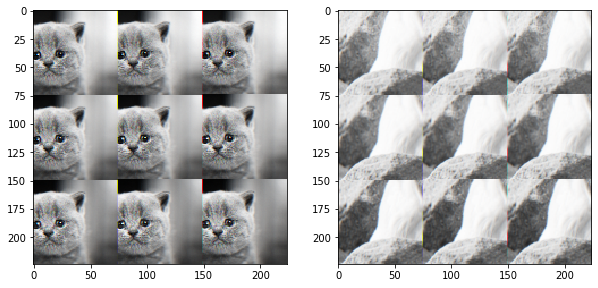

In [55]:
import matplotlib
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(1,2,1)
cat = img_data.__getitem__(0)[0].reshape(224,-1,3)
ax1.imshow(cat,cmap = matplotlib.cm.binary,interpolation='nearest')
ax2=fig.add_subplot(1,2,2)
dog = img_data.__getitem__(1)[0].reshape(224,-1,3)
ax2.imshow(dog,cmap = matplotlib.cm.binary,interpolation='nearest')
plt.show()

# Model

In [66]:
def conv_2_block(in_dim,out_dim):
  model = nn.Sequential(
      nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1), # convolution
      nn.ReLU(), # activation function
      nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1), # convolution
      nn.ReLU(), # activation function
      nn.MaxPool2d(2,2) # Pooling
  )
  return model

def conv_3_block(in_dim,out_dim):
  model = nn.Sequential(
      nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
      nn.ReLU(),
      nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
      nn.ReLU(),
      nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
  )
  return model


In [67]:
class VGG(nn.Module): # dog,cat 두가지이므로
    def __init__(self, base_dim, num_classes=2):
        super(VGG, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim),
            conv_2_block(base_dim,2*base_dim),
            conv_3_block(2*base_dim,4*base_dim),
            conv_3_block(4*base_dim,8*base_dim),
            conv_3_block(8*base_dim,8*base_dim)           
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(8*base_dim * 7 * 7, 100),
            nn.ReLU(True), # inplace=True                                                      
            nn.Linear(100, 20),
            nn.ReLU(True),
            nn.Linear(20, num_classes)
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)                                               
        x = self.fc_layer(x)
        return x

In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [69]:
model = VGG(base_dim = 16).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
for i in model.named_children():
  print(i)

('feature', Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(


In [70]:
loss_arr=[]
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    if i % 10 ==0:
        loss_arr.append(loss)
        print(loss)

tensor(0.7435, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7083, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6613, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4604, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9431, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0697, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3877, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0638, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8814, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2638, device='cuda:0', grad_fn=<NllLossBackward>)


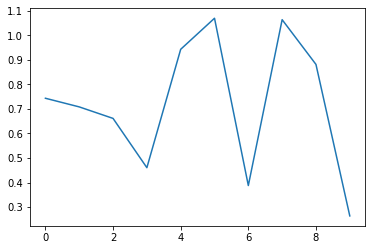

In [72]:
plt.plot(loss_arr)
plt.show()